In [ ]:
!pip install "dask[complete]"

Dashboard link: http://127.0.0.1:57644/status
Đã lưu biểu đồ vào file 'weather_analysis_demo.png'
Ngày nóng nhất: 2044-03-31 với nhiệt độ 28.84°C
Ngày lạnh nhất: 2088-06-08 với nhiệt độ 20.93°C


Exception in callback multi_future.<locals>.callback(<Task cancell...ession.py:77>>) at C:\Users\Admin\OneDrive\Desktop\datascience\.venv\Lib\site-packages\tornado\gen.py:523
handle: <Handle multi_future.<locals>.callback(<Task cancell...ession.py:77>>) at C:\Users\Admin\OneDrive\Desktop\datascience\.venv\Lib\site-packages\tornado\gen.py:523>
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Admin\OneDrive\Desktop\datascience\.venv\Lib\site-packages\tornado\gen.py", line 529, in callback
    result_list.append(f.result())
                       ^^^^^^^^^^
  File "C:\Users\Admin\OneDrive\Desktop\datascience\.venv\Lib\site-packages\bokeh\server\session.py", line 88, in _needs_document_lock_wrapper
    with await self._lock.acquire():
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
asyncio.exceptions.CancelledError
Exception in callback multi_fut

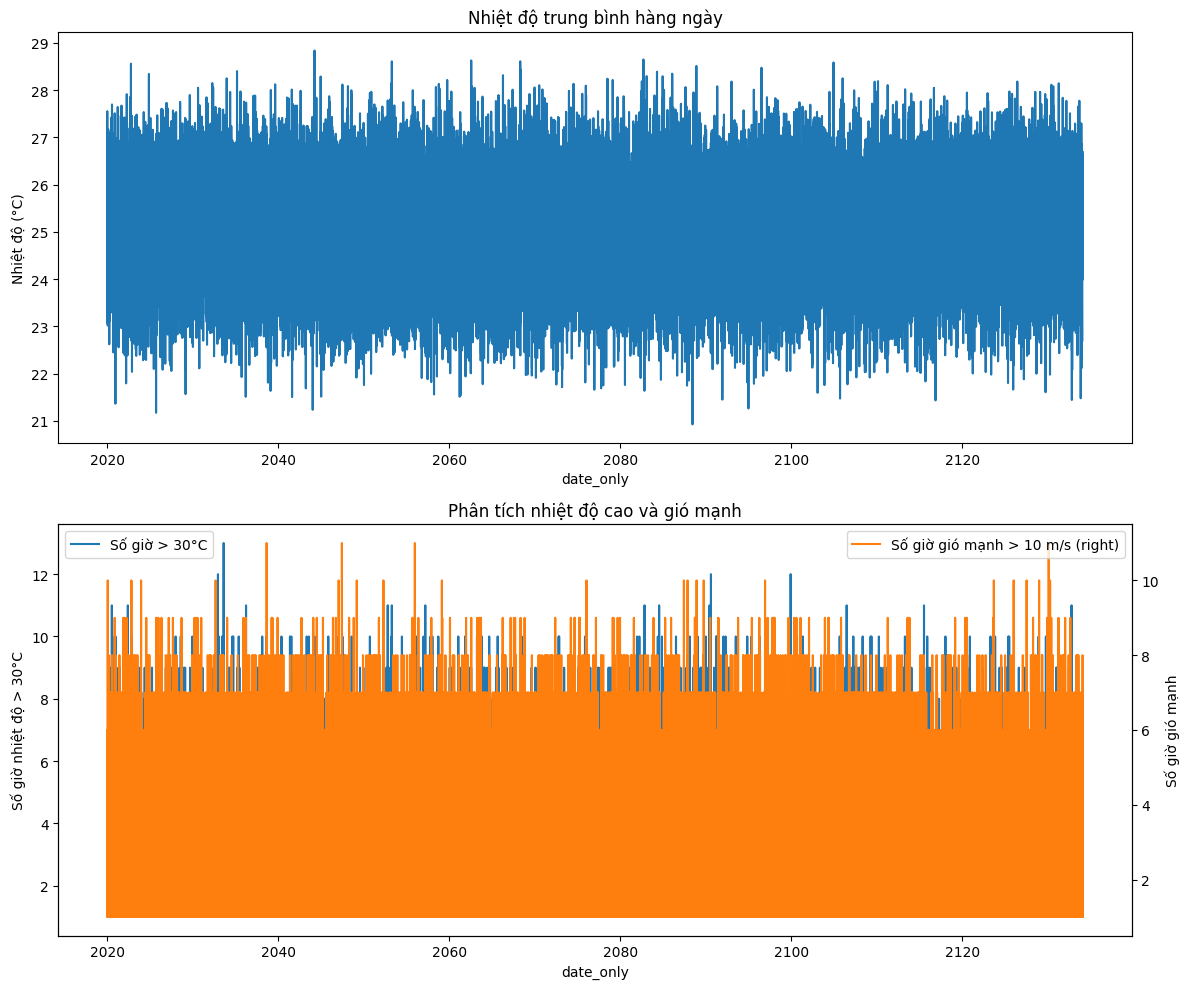

In [13]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from dask.distributed import Client
import matplotlib.pyplot as plt

# Hàm tạo dữ liệu mẫu
def create_sample_data(num_partitions, rows_per_partition):
    def generate_partition(partition_id):
        np.random.seed(partition_id)
        start_date = pd.Timestamp('2020-01-01') + pd.Timedelta(hours=partition_id * rows_per_partition)
        dates = pd.date_range(start=start_date, periods=rows_per_partition, freq='H')
        df = pd.DataFrame({
            'date': dates,
            'temperature': np.random.normal(25, 5, rows_per_partition),
            'humidity': np.random.uniform(60, 90, rows_per_partition),
            'wind_speed': np.random.exponential(5, rows_per_partition)
        })
        return df
    
    return dd.from_map(generate_partition, range(num_partitions), meta={
        'date': 'datetime64[ns]',
        'temperature': 'float64',
        'humidity': 'float64',
        'wind_speed': 'float64'
    })

# Khởi tạo Dask Client
client = Client(dashboard_address=':0')  # Sử dụng port ngẫu nhiên
print(f"Dashboard link: {client.dashboard_link}")

# Tạo dữ liệu mẫu (khoảng 1 triệu bản ghi)
df = create_sample_data(num_partitions=10, rows_per_partition=100000)

# Thêm cột date_only để groupby
df['date_only'] = df.date.dt.date

# Phân tích dữ liệu
daily_avg = df.groupby('date_only').agg({
    'temperature': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean'
}).compute()

# Tìm ngày nóng nhất và lạnh nhất
hottest_day = daily_avg.loc[daily_avg.temperature.idxmax()]
coldest_day = daily_avg.loc[daily_avg.temperature.idxmin()]

# Tính toán thêm
temp_over_30 = df[df.temperature > 30].groupby('date_only').size().compute()
high_wind_days = df[df.wind_speed > 10].groupby('date_only').size().compute()

# Vẽ biểu đồ
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

daily_avg.temperature.plot(ax=ax1)
ax1.set_title('Nhiệt độ trung bình hàng ngày')
ax1.set_ylabel('Nhiệt độ (°C)')

temp_over_30.plot(ax=ax2, label='Số giờ > 30°C')
high_wind_days.plot(ax=ax2, secondary_y=True, label='Số giờ gió mạnh > 10 m/s')
ax2.set_title('Phân tích nhiệt độ cao và gió mạnh')
ax2.set_ylabel('Số giờ nhiệt độ > 30°C')
ax2.right_ax.set_ylabel('Số giờ gió mạnh')
ax2.legend(loc='upper left')
ax2.right_ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('weather_analysis_demo.png')
print("Đã lưu biểu đồ vào file 'weather_analysis_demo.png'")

print(f"Ngày nóng nhất: {hottest_day.name} với nhiệt độ {hottest_day.temperature:.2f}°C")
print(f"Ngày lạnh nhất: {coldest_day.name} với nhiệt độ {coldest_day.temperature:.2f}°C")

# Đóng client
client.close()